<a href="https://colab.research.google.com/github/ElenaManari/MLPNS_EManari/blob/main/Copia_di_my_CNN_sliding_windows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTANTE: Impostare come runtime GPU per accelerare il training
#e non metterci una vita

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importo i vari pacchetti

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [ ]:
#per ragioni estetiche sistemo alcuni parametri visuali del plotting
#sistemo la dimensione delle immagini
#non voglio fare interpolazioni sulle immagini
#metto una mappa di colori in bianco e nero

plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray"

In [ ]:
cd /content/drive/MyDrive/MLPNS2023

/content/drive/MyDrive/MLPNS2023


In [ ]:
ls 

kaggleTitanic/  spm/                          wine.data
model.png       spm-20210427T111354Z-001.zip  wine.names


In [ ]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
replace spm/spm_struct_pos.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spm/spm_struct_pos.npy  
replace spm/spm_struct_neg.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spm/spm_struct_neg.npy  
replace spm/test_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spm/test_good_all.npy   
replace spm/train_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spm/train_good_all.npy  
replace spm/test_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spm/test_bad_all.npy    
replace spm/train_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: spm/train_bad_all.npy   y
y



In [ ]:
#sono tutti numpy arrays, e la funzione per leggerli è:
#np.load
#invece per salvarli si usa:
#np.save

#carichiamo i training data, utilizzeremo questo come training set
#e lo spacchetteremo in due sets come training set e test set
data = np.load("spm/train_good_all.npy")

In [ ]:
data.shape
#sono 1302 di dimensione 64x64

(1302, 64, 64)

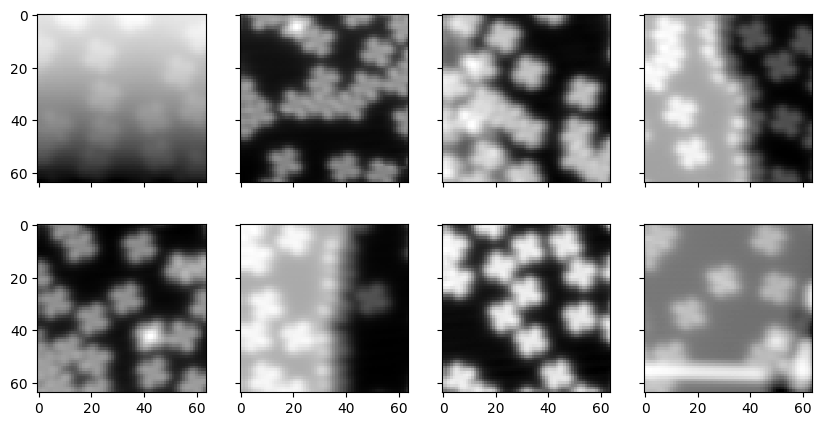

In [ ]:
#plotto le prime 8 immagini del mio set di dati giusto per capire
fig, ax = plt.subplots(2, 4, figsize=[10,5], sharex=True, sharey=True)

for ii in range(8):
  ax[ii // 4, ii % 4].imshow(data[ii])

Voglio costruire un CNN che impari la forma delle molecole e ne riconosca la posizione nelle varie immagini che ho a disposizione. 

(array([ 254226.,  957465., 1143646., 1050540.,  825288.,  338534.,
         391059.,  151471.,  179803.,   40960.]),
 array([-1.07775726e-07, -9.55749615e-08, -8.33741970e-08, -7.11734324e-08,
        -5.89726678e-08, -4.67719032e-08, -3.45711387e-08, -2.23703741e-08,
        -1.01696095e-08,  2.03115507e-09,  1.42319196e-08]),
 <BarContainer object of 10 artists>)

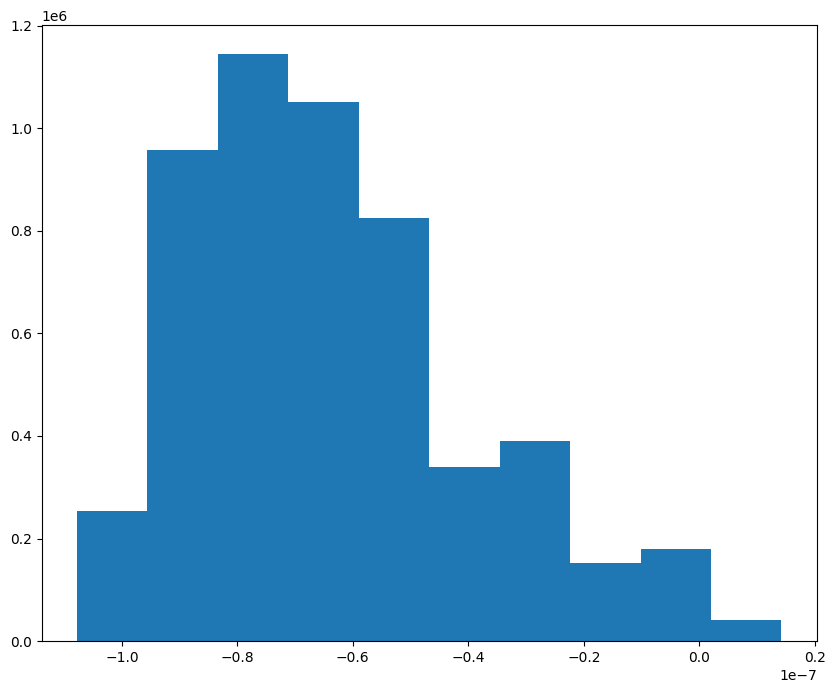

In [ ]:
plt.hist(data.flatten())

In [ ]:
#la prima cosa che si fa come operazione di preprocessing è creare una 
#operazione normalizzata, come:

# norm= (D - min(D)) / range(D)

#Dove D sono i miei data. Va bene questa normalizzazione in quanto la 
#distribuzione è continua, gaussiana e non ha gaps

norm = (data - data.min(axis=(1, 2), keepdims=True)) / (data.max(axis=(1, 2), keepdims=True) - 
                                                        data.min(axis=(1, 2), keepdims=True))



In [ ]:
norm.min(), norm.max()

(0.0, 1.0)

In [ ]:
norm.shape

(1302, 64, 64)

In [ ]:
#passiamo al codice la posizione delle molecole

#leggo le labels positive
pos = np.load("spm/spm_struct_pos.npy")
#leggo le labels negative
neg = np.load("spm/spm_struct_neg.npy")

In [ ]:
pos.shape, neg.shape

((500, 3), (500, 3))

In [ ]:
pos[0]

array([30, 25, 51])

In [ ]:
pos.max(axis=0)

array([  62,   62, 1300])

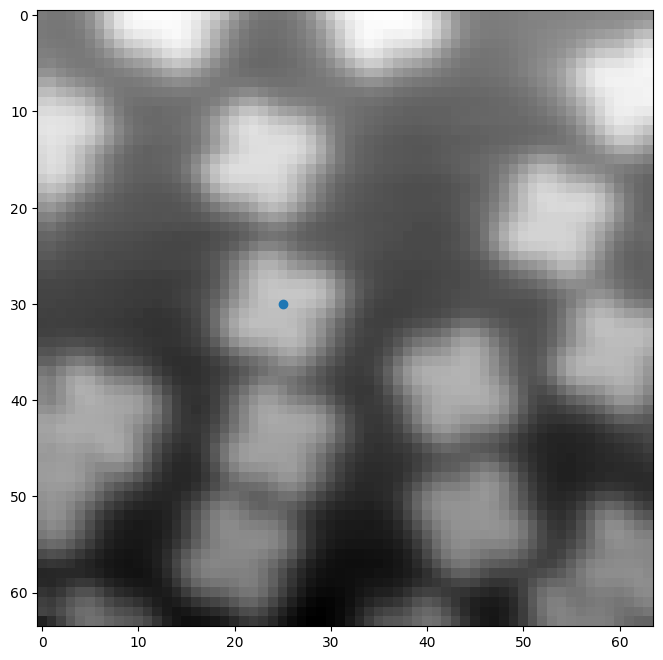

In [ ]:
#testing per vedere come è stata fatta la posizione delle molecole e dei
#loro centri, prendo l'immagine 51 ad esempio
plt.imshow(norm[pos[0][2]])
plt.plot(pos[0][1], pos[0][0], 'o')

Per semplificare le cose, creo delle immagini che contengono solo le molecole e delle immagini che non contengono le molecole, in maniera tale da insegnare al neural network come distinguere una molecola. Creiamo uno sliding windows detector. 

Creerò dei francobolli (delle mini immagini) centrate attorno alla molecola, con dimensione circa 20 x 20, e metterò come hyperparameter wid=10.

In [ ]:
wid = 10
stmp_pos = []
for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_pos.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid,])

stmp_pos = np.array(stmp_pos)

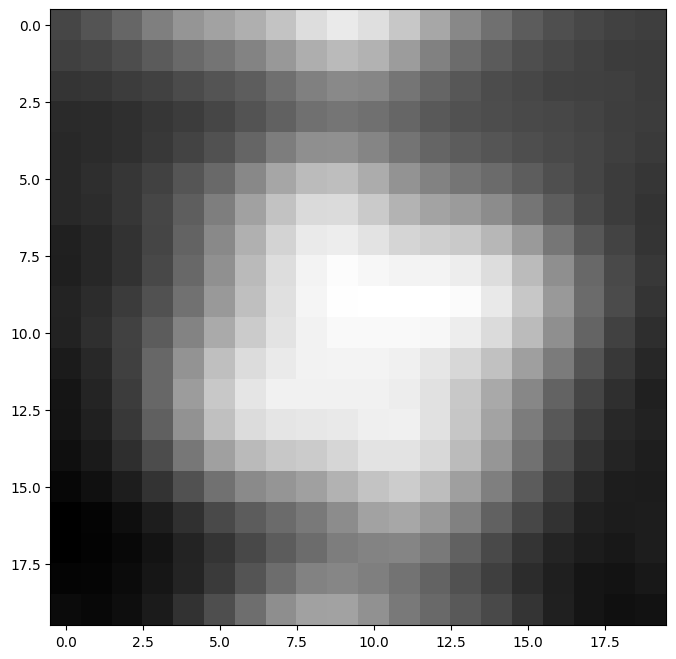

In [ ]:
plt.imshow(stmp_pos[0])

Ho costruito un francobollo contenente la molecola, chiamato stmp_pos.

In [ ]:
wid = 10
stmp_neg = []

for ii in range(pos.shape[0]):
  trow, tcol, tind = neg[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid,])

stmp_neg = np.array(stmp_neg)

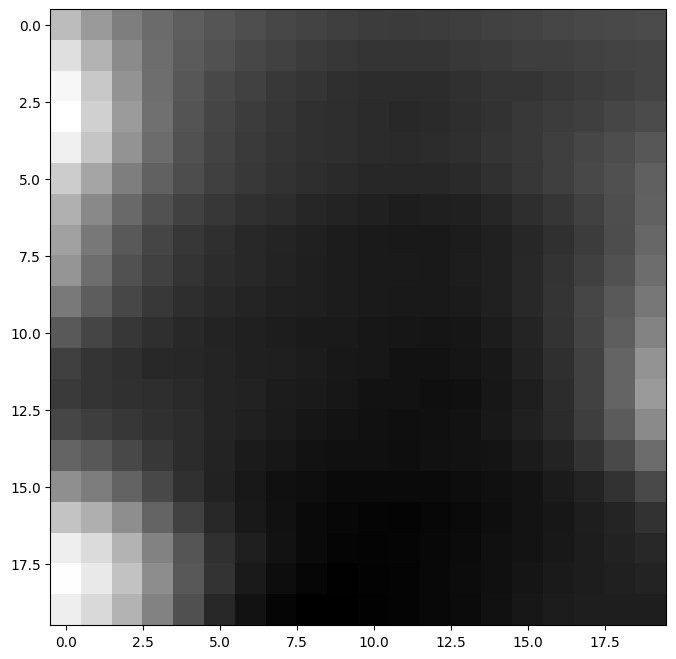

In [ ]:
plt.imshow(stmp_neg[0])

Ho costruito un francobollo non contenente una molecola, chiamato stmp_neg.

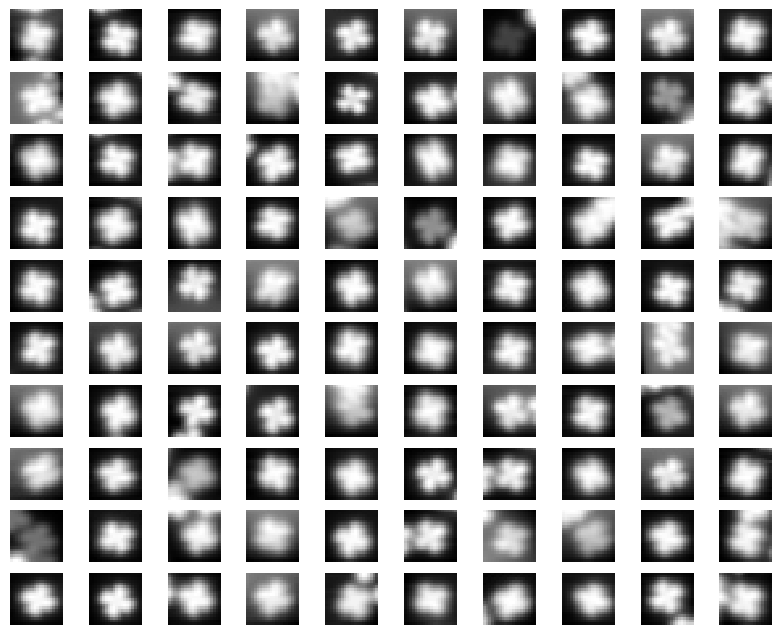

In [ ]:
#vediamo una serie delle mie annotazioni positive

fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")

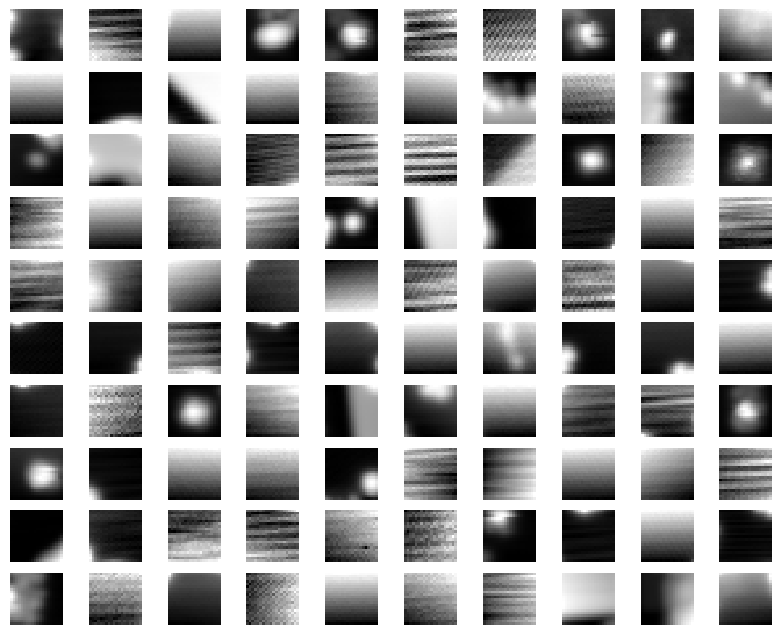

In [ ]:
#vediamo una serie delle mie annotazioni negative 

fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")

In [ ]:
#faccio il training test, settando le feature e il target
#nel target assegno con valore 0 le feature negative senza molecola
#e valore 1 per la feature positive con la molecola
feat = np.concatenate((stmp_neg, stmp_pos), axis=0)
targ = np.concatenate((np.zeros(stmp_neg.shape[0]), 
                      np.ones(stmp_pos.shape[0])))

In [ ]:
stmp_neg.shape, stmp_pos.shape

#più o meno ho lo stesso numero di positive
#and negative stamps.

((485, 20, 20), (389, 20, 20))

In [ ]:
train_test_split?

In [ ]:
#devo assicurarmi di mescolare i dati, perché altrimenti il neural
#network potrebbe imparare che i primi dati che gli arrivano sono positive
#e gli ultimi che gli arrivano sono i negative
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ,
                                                      random_state=302, shuffle=True)

feat_tr.shape

(655, 20, 20)

In [ ]:
#devo cambiare dimensione dell'array per fargli capire che le mie
#immagini sono in bianco e nero, in genere ci vogliono tre assi R,G,B
#per i colori, in questo caso ho (20, 20), ma voglio (20, 20, 1)

feat_tr = np.expand_dims(feat_tr, axis=3)
feat_te = np.expand_dims(feat_te, axis=3)
feat_tr.shape

(655, 20, 20, 1)

#Creiamo il Convolutional Neural Network:

Architettura del network:

- conv2d 16 neurons
- maxpool2d 2x2
- conv2d 32 neurons
- maxpool2d 2x2
- flatten
- dense 64 neurons
- dense 2 neurons (questo perché avrò due risultati) 

kernel_size -> dimensione della feature map

input_shape -> dobbiamo dire la shape dei dati (20x20x1)

kernel_regilarizer -> diamo una
regolarizzazione utile per evitare overfitting

In [ ]:
keras.layers.Dense?

In [ ]:
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1), #needed in the first layer only
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer2 = keras.layers.MaxPool2D(2)

layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer4 = keras.layers.MaxPool2D(2)

layer5 = keras.layers.Flatten()

#l'activation function nel layer6 è opzionale, potrebbe essere relu oppure
#anche linear
layer6 = keras.layers.Dense(64, activation="relu",
                            kernel_regularizer=keras.regularizers.l2(0.001))

#softmax restituisce valori binari, 0 oppure 1
layer7 = keras.layers.Dense(2, activation="softmax")


layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 64)                5

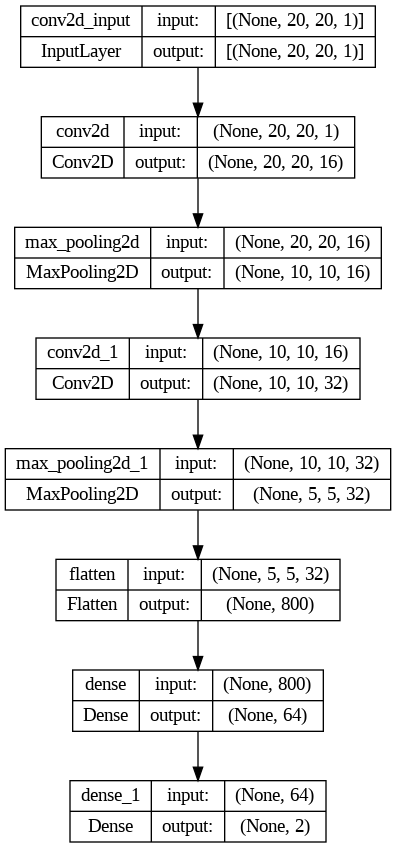

In [ ]:
#abbiamo 64000 parametri, un po' più serio

keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#per optimizer usiamo adam di default
#mettiamo una loss function categorica, in quanto i dati finali sono
#categorici, con sparse_categorical_crossentropy ed è una loss function
#stile softmax, e usiamo come metrica accuracy

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
              metrics="accuracy")

In [ ]:
#facciamo il fitting con una variabile history per fare un plot della
#loss function via via che itero. Scelgo come epoche 50, che va bene per
#questo problema semplice. La batch size serve per ridurre l'overfitting.
#validation split serve per fare una valutazione interna sui dati

history = model.fit(feat_tr, targ_tr, epochs=50,
                    batch_size=50, validation_split=0.1)

Epoch 1/50
12/12 [==============================] - 11s 50ms/step - loss: 0.7233 - accuracy: 0.7878 - val_loss: 0.5643 - val_accuracy: 0.9091
Epoch 2/50
12/12 [==============================] - 0s 6ms/step - loss: 0.4906 - accuracy: 0.8998 - val_loss: 0.3467 - val_accuracy: 0.9091
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.3479 - accuracy: 0.9134 - val_loss: 0.3543 - val_accuracy: 0.9091
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 0.3276 - accuracy: 0.9100 - val_loss: 0.2733 - val_accuracy: 0.8939
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.2711 - accuracy: 0.9389 - val_loss: 0.2716 - val_accuracy: 0.9394
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2361 - accuracy: 0.9508 - val_loss: 0.2495 - val_accuracy: 0.9394
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 0.2177 - accuracy: 0.9440 - val_loss: 0.2123 - val_accuracy: 0.9545
Epoch 8/50
12/12 [

In [ ]:
history.history["val_accuracy"]

[0.9090909361839294,
 0.9090909361839294,
 0.9090909361839294,
 0.8939393758773804,
 0.939393937587738,
 0.939393937587738,
 0.9545454382896423,
 0.9242424368858337,
 0.9696969985961914,
 0.939393937587738,
 0.9545454382896423,
 0.9545454382896423,
 0.939393937587738,
 0.9545454382896423,
 0.9848484992980957,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9848484992980957,
 0.9848484992980957,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9848484992980957,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9696969985961914,
 0.9848484992980957,
 0.9696969985961914,
 0.9545454382896423,
 0.9848484992980957,
 0.9696969985961914,
 0.9696969985961914,
 0.96969699859619

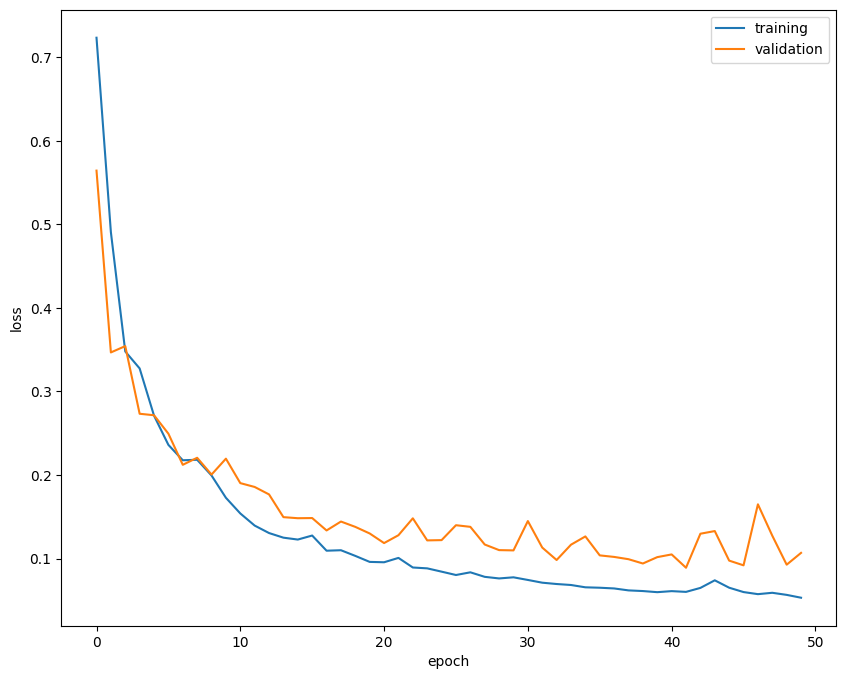

In [ ]:
plt.plot(history.history["loss"], label= "training")
plt.plot(history.history["val_loss"], label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

Sembra ci sia un leggero overfitting poiché pare che vi sia una leggera distanza tra training curve e validation curve. Il fatto che vi siano loss curves noisy è perché è un problema difficile. Spesso per ridurre il noise converrebbe ridurre il learning rate.

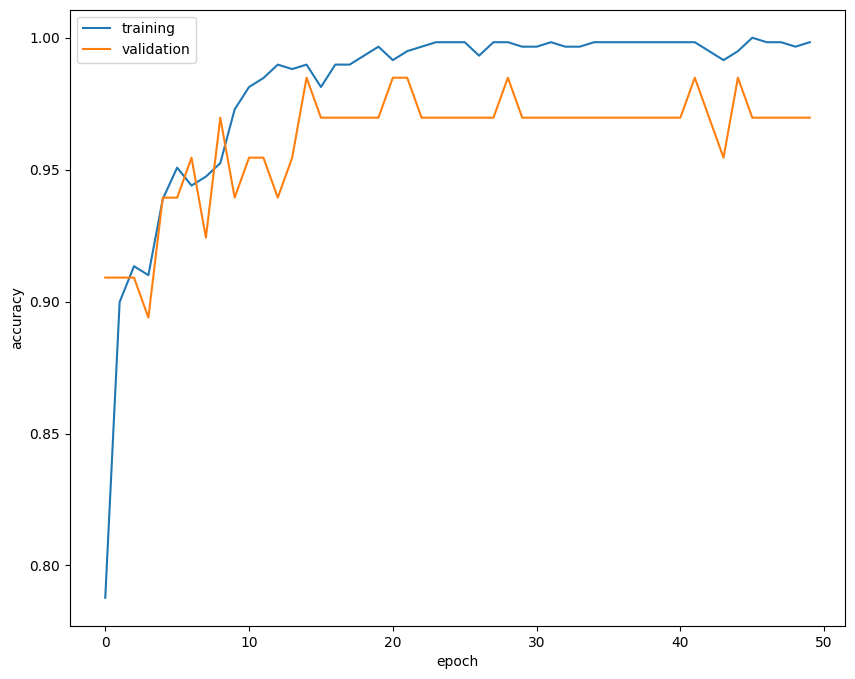

In [ ]:
plt.plot(history.history["accuracy"], label= "training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

Anche l'accuracy va di pari passo con la loss function.

In [ ]:
loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te)
print("{:.2f}, {:.2f}, {:.2f}, {:.2f}".format(loss_tr, acc_tr, loss_te, acc_te)) 

7/7 [==============================] - 0s 11ms/step - loss: 0.1122 - accuracy: 0.9863
0.06, 1.00, 0.11, 0.99


Finora abbiamo creato un neural network che riconosce un poster stamp di dimensione 20 x 20 che studia se quell'oggetto è una molecola oppure no. Siccome abbiamo una classificazione probabilistica, dobbiamo avere un risultato di più alta confidenza via via che ci avviciniamo al centro della molecola. Creiamo ora un poster stamp suddividendo in blocchi 20x20 tutte le immagini.

In [ ]:
pos[0]

array([30, 25, 51])

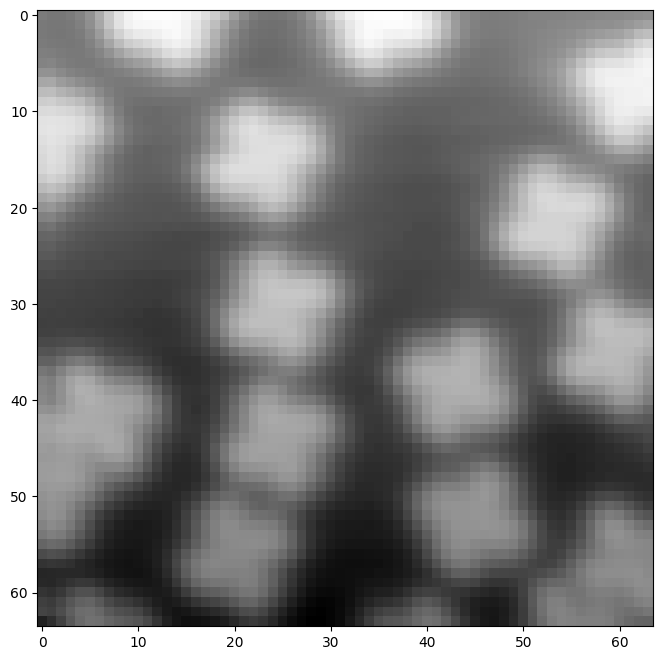

In [ ]:
plt.imshow(norm[51])

In [ ]:
#facciamo un'immagine di prova per vedere come separo questa immagine
img = norm[51].copy()

In [ ]:
wid

10

In [ ]:
nrow, ncol = img.shape
#costruisco i miei stamps 20x20 come array
#stamps= np.zeros((N_images, N_rows, N_columns))
stamps = np.zeros(((nrow - wid * 2) * (ncol - wid * 2), 2 * wid, 2 * wid))
stamps.shape

#aggiungo un counter kk
kk = 0
for ii in range(wid, nrow - wid): #loop on rows
  for jj in range(wid, ncol - wid): #loop on cols
    stamps[kk] = img[ii-wid:ii+wid, jj-wid:jj+wid]
    kk += 1

feat_stmp = np.expand_dims(stamps, axis=3)


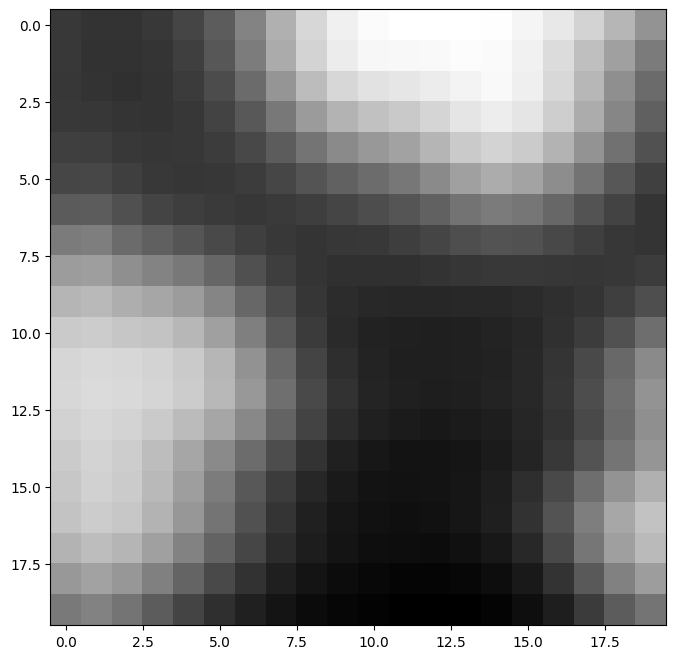

In [ ]:
plt.imshow(feat_stmp[0])

In [ ]:
pred = model.predict(feat_stmp)

61/61 [==============================] - 0s 2ms/step
